# Global Coffee Health: End-to-End ML Pipeline (Classification)
## by Yegorchenkov Platon (GH1024875)
- GitHub URL: https://github.com/baby-platom/uni-ai-ml
- Dataset source URL: https://www.kaggle.com/datasets/uom190346a/global-coffee-health-dataset

## Problem Statement
A coffee company wants to be able to predict the **sleep quality** of the customers. In case the anticipated **sleep quality** is low, the health routines (lower-caffeine options, decaff, personalized recommendation) can be promoted to the customers. If we can relatively reliably anticipate the poor sleep, we could:
- `Reduce churn rates & increase the Lifetime Value`: if we proactively handle the at-risk users, we can suggest healthier consumption patterns
- `Boost customer wellbeing`: if there're fewer sleep complaints, the sattisfaction and brand trust are on the higher levels
- `Tailor the products`: target content and the related recommendations based on a risk level

### Data collection
The data, in practice, could originate from
- User profile: age, gender, country, occupation
- Habit tracking: the number of cups per day, physical activities, the bad habits
- Wearables: heart rate, sleep hours

In practice, we have an already collected dataset with the numerous rich features

### Goal
Predict **sleep quality** (Excellent / Good / Fair / Poor) based on the lifestyle, coffee consumption and demographics. 

### ML task
Multitask classification to predict `Sleep_Quality ∈ {Excellent, Good, Fair, Poor}`

**Success criteria**: We want to get the balanced performance across the classes (not just the majority). Use `Macro-F1` and `Balanced Accuracy` as the primary metrics. Additionally, use confusion matrix and classification report (precision, recall, and F1 for each class).


## Data Exploration

In [1]:
from pathlib import Path

import pandas as pd

SEED = 42

data_path = Path("dataset.csv")
df = pd.read_csv(data_path)

df.head()

,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


In [2]:
df.shape, df.dtypes

((10000, 16),
 ID                           int64
 Age                          int64
 Gender                      object
 Country                     object
 Coffee_Intake              float64
 Caffeine_mg                float64
 Sleep_Hours                float64
 Sleep_Quality               object
 BMI                        float64
 Heart_Rate                   int64
 Stress_Level                object
 Physical_Activity_Hours    float64
 Health_Issues               object
 Occupation                  object
 Smoking                      int64
 Alcohol_Consumption          int64
 dtype: object)

In [3]:
missing = df.isna().sum().sort_values(ascending=False)
duplicates = df.duplicated().sum()
missing, duplicates

(Health_Issues              5941
 ID                            0
 Age                           0
 Gender                        0
 Country                       0
 Coffee_Intake                 0
 Caffeine_mg                   0
 Sleep_Hours                   0
 Sleep_Quality                 0
 BMI                           0
 Heart_Rate                    0
 Stress_Level                  0
 Physical_Activity_Hours       0
 Occupation                    0
 Smoking                       0
 Alcohol_Consumption           0
 dtype: int64,
 np.int64(0))

The only column that has "missing values" is `Health_Issues`. However, when a cell in the `Health_Issues` column is `NaN`, it means that a person just has no health issues. 

Since for categorical features we will use a `OneHotEncoder`, it will encode it just as one of the categories. Considering that there're 10 thousand rows in total, the 5941 records with no `Health_Issues` is the most popular category for this feature.

We also have no duplicates

### Dependent variable distribution

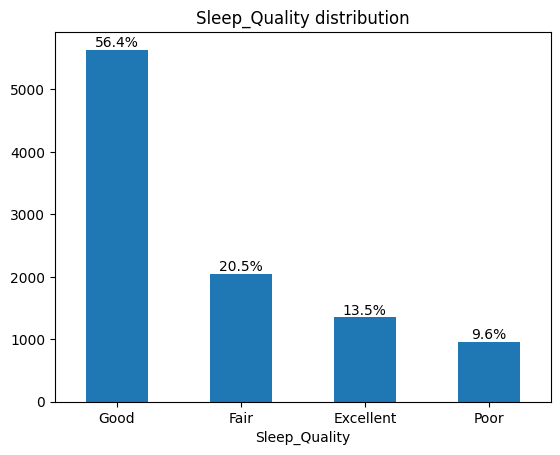

In [4]:
import matplotlib.pyplot as plt

ax = df["Sleep_Quality"].value_counts().plot(kind="bar", rot=0)
ax.set_title("Sleep_Quality distribution")

total = len(df)
for p in ax.patches:
    height = p.get_height()
    percent = f"{height / total:.1%}"
    ax.text(p.get_x() + p.get_width() / 2, height, percent, ha="center", va="bottom")

plt.show()

We can observe that the `Sleep_Quality` is imbalanced, though not extremely:
- `Good` makes up over a half of the observed cases
- `Poor` accounts for less than 10%

To handle this, we will, firstly, use `stratified splits` to ensure that the class proportions remain the same within the subsets. Secondly, we should use `balanced accuracy` to treat the imbalance.

## Leakage

In [5]:
df.groupby("Sleep_Quality")["Sleep_Hours"].agg(["mean", "std", "count"])

,mean,std,count
Sleep_Quality,,,
Excellent,8.593565,0.499959,1352
Fair,5.576732,0.278688,2050
Good,6.924446,0.549481,5637
Poor,4.451925,0.456320,961


The `Sleep_Quality` is likely a binning of `Sleep_Hours`:
- Excellent ≈ 8.59h
- Good ≈ 6.92h
- Fair ≈ 5.58h
- Poor ≈ 4.45h

Except for the **Monotonic ordering** (the higher sleep hours mean better quality) we also observe:
- Small standard deviation: every group has tight clustering
- Clear thresholds: the mean values are near the integer values, like bins boundaries

So, it's very likely that the `Sleep_Quality` is derived from `Sleep_Hours`. To avoid the leakage, we will drop the `Sleep_Hours`.

In [6]:
pd.crosstab(df["Sleep_Quality"], df["Stress_Level"])

Stress_Level,High,Low,Medium
Sleep_Quality,,,
Excellent,0,1352,0
Fair,0,0,2050
Good,0,5637,0
Poor,961,0,0


It's another leakege and here it's perfect: every `Sleep_Quality` level is strictly matched with a corresponding `Stress_Level`. We will also drop the `Stress_Level`.

## Redundancy analysis

In [7]:
(df[["Caffeine_mg", "Coffee_Intake"]].corr().iloc[0, 1])

np.float64(0.9998135731303948)

The correlation between `Caffeine_mg` and `Coffee_Intake` is extremely high, we could anticipate that. One of the columns is redundant, we will keep `Coffee_Intake` (it's easier to interpret) and drop the `Caffeine_mg`

In [8]:
pd.crosstab(df["Health_Issues"], df["Sleep_Quality"], normalize="index", dropna=False)

Sleep_Quality,Excellent,Fair,Good,Poor
Health_Issues,,,,
Mild,0.060352,0.491199,0.221011,0.227438
Moderate,0.012959,0.600432,0.075594,0.311015
Severe,0.000000,0.823529,0.000000,0.176471
NaN,0.190204,0.000000,0.809796,0.000000


The `Health_Issues` seems to be highly alligned with the `Sleep_Quality`. So the `Health_Issues` seems not to be an independent predictor. This may dominate and mask the other casual effects in the model.

To be conservative about causality, we'll check the model without (excluding) the `Health_Issues` during the sensitivity analysis. 

## Numeric relationships

In [9]:
num = df.select_dtypes("number").drop(columns=["ID"])
num.corr()["Sleep_Hours"].sort_values(ascending=False)

Sleep_Hours                1.000000
BMI                        0.008463
Smoking                    0.007955
Age                        0.005010
Alcohol_Consumption       -0.003375
Physical_Activity_Hours   -0.011228
Heart_Rate                -0.036219
Coffee_Intake             -0.190291
Caffeine_mg               -0.190493
Name: Sleep_Hours, dtype: float64

The strongest correlations are among `Coffee_Intake` and `Caffeine_mg`: about `-0.190` for each. Though it reflects that the people consuming more caffeine tend to sleep less, the correlation is weak. 

## Problem formulation & metrics
- `Task`: Mutliclass classification of `Sleep_Quality ∈ {Excellent, Good, Fair, Poor}`
- `Primary metrics`: Macro-F1, to treat the classes equally, and Balanced Accuracy, to handle the imbalance of the dataset.
- `Secondary metrics`: Accuracy, recall, confusion matrix.

### Data split
We are going have `train` (60%), `validation` (20%), and `test` (20%) subsets stratified based on the target (Sleep_Quality). The `validation` subset will be used for model selection and the hyperparameters tuning. The `test` is left untouched until final assessment.

## Data preprocessing & feature engineering
Firstly, we right away drop the following columns:
- `ID`: as it's just the identifier and is not an actual feature
- `Sleep_Hours`: leakege detected. It's just the binning of the `Sleep_Quality`
- `Stress_Level`: perfect leakege of `Sleep_Quality`.
- `Caffeine_mg`: redundant

The kept features: Age, Gender, Country, Coffee_Intake, BMI, Heart_Rate, Physical_Activity_Hours, Health_Issues, Occupation, Smoking, Alcohol_Consumption

**Transformations**:
- Numeric: `StandardScaler`
- Categorical: `OneHotEncoder(handle_unknown='ignore')`


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

TARGET = "Sleep_Quality"
DROP = ["ID", "Sleep_Hours", "Stress_Level", "Caffeine_mg"]

X = df.drop(columns=DROP + [TARGET])
y = df[TARGET]

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=SEED, stratify=y_temp
)

num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    [
        ("num", StandardScaler(), num_features),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            cat_features,
        ),
    ]
)

## Baseline
`Majority class baseline`: use as a ground floor

In [11]:
from collections import Counter
import numpy as np
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score

maj_label = Counter(y_train).most_common(1)[0][0]
y_pred_majority = np.full_like(y_val, fill_value=maj_label)

print("Majority baseline:")
print("  Acc:", accuracy_score(y_val, y_pred_majority))
print("  Macro‑F1:", f1_score(y_val, y_pred_majority, average="macro"))
print("  BalAcc:", balanced_accuracy_score(y_val, y_pred_majority))

Majority baseline:
  Acc: 0.5635
  Macro‑F1: 0.18020466901183244
  BalAcc: 0.25


## Model training & selection
The good way to choose a highly appropriate model, is to compare several ones. We will compare:
- `Logistic Regression`: interpretable and a way to check the linear effects
- `Random Forest`: strong general-purpose option
- `HistGradientBoostingClassifier`: more powerful for complex patterns

At this step, we are using small grids, just to identify the best performing model, based on the `Macro‑F1` and the validation set. On the next next, we will conduct a broader hyperparameters search for the winner model.

In [25]:
from IPython.display import display

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid

candidates = {
    "logreg": {
        "est": LogisticRegression(
            max_iter=500,
            class_weight="balanced",
            random_state=SEED,
        ),
        "grid": {"model__C": [0.5, 1.0, 2.0]},
    },
    "rf": {
        "est": RandomForestClassifier(random_state=SEED, class_weight="balanced"),
        "grid": {
            "model__n_estimators": [250],
            "model__max_depth": [None, 16],
            "model__min_samples_leaf": [1, 3],
        },
    },
    "hgb": {
        "est": HistGradientBoostingClassifier(random_state=SEED),
        "grid": {
            "model__learning_rate": [0.05, 0.1],
            "model__max_depth": [None, 8],
            "model__l2_regularization": [0.0, 0.1],
        },
    },
}

results = []
best = {"model": None, "params": None, "pipe": None, "macro_f1": -1}

for name, spec in candidates.items():
    for params in ParameterGrid(spec["grid"]):
        pipe = Pipeline(
            [
                ("prep", preprocess),
                ("model", spec["est"].__class__(**spec["est"].get_params())),
            ]
        )

        pipe.set_params(**params)
        pipe.fit(X_train, y_train)

        y_pred = pipe.predict(X_val)
        f1 = f1_score(y_val, y_pred, average="macro")
        acc = accuracy_score(y_val, y_pred)

        results.append({"name": name, "params": params, "macro_f1": f1, "acc": acc})
        if f1 > best["macro_f1"]:
            best = {
                "model": name,
                "params": params,
                "pipe": pipe,
                "macro_f1": f1,
                "acc": acc,
            }

model_selection_df = pd.DataFrame(results).sort_values(
    ["macro_f1", "acc"], ascending=False
)
display(model_selection_df.head(10))

print(
    "Best model:",
    {
        "model": best["model"],
        "params": best["params"],
        "macro_f1": best["macro_f1"],
        "acc": best["acc"],
    },
)

,name,params,macro_f1,acc
6,rf,"{'model__max_depth': 16, 'model__min_samples_l...",0.492227,0.7215
13,hgb,"{'model__l2_regularization': 0.1, 'model__lear...",0.484414,0.7425
4,rf,"{'model__max_depth': None, 'model__min_samples...",0.484385,0.7485
9,hgb,"{'model__l2_regularization': 0.0, 'model__lear...",0.476733,0.7365
10,hgb,"{'model__l2_regularization': 0.0, 'model__lear...",0.473626,0.7375
14,hgb,"{'model__l2_regularization': 0.1, 'model__lear...",0.473308,0.7380
11,hgb,"{'model__l2_regularization': 0.1, 'model__lear...",0.472897,0.7515
8,hgb,"{'model__l2_regularization': 0.0, 'model__lear...",0.472684,0.7520
7,hgb,"{'model__l2_regularization': 0.0, 'model__lear...",0.464390,0.7485
5,rf,"{'model__max_depth': 16, 'model__min_samples_l...",0.462619,0.7545


Best model: {'model': 'rf', 'params': {'model__max_depth': 16, 'model__min_samples_leaf': 3, 'model__n_estimators': 250}, 'macro_f1': 0.49222746352630703, 'acc': 0.7215}


### Results
The best performing model is Random Forest with the `{'model__max_depth': 16, 'model__min_samples_leaf': 3, 'model__n_estimators': 250}` params. It has `Macro‑F1` = 0.492 and `Accuracy` = 0.7215

We can notice another Random Forest config with the `'model__max_depth': None`, it reaches `Macro‑F1` of 0.484, but it tends to have a highe variance.

`HistGradientBoostingClassifier` has better `Accuracy` results of about ~0.74–0.75, but we priorotize the `Macro‑F1` score, as our priority is the balanced performance across the classes. Overall, RF and HGB are performing similiarly well, while the LG is not even in the top 10.

`Conclusion`: We will prefer RF, since it demonstrates the best `Macro‑F1` score, which is our primary metric. Additionally, as we have one‑hot encoded high‑cardinality categoricals and possible non‑linear interactions, the RF often yields good results. 

## Sensitivity analysis
We have detected before that `Health_Issues` is highly alligned with `Sleep_Quality`

To check how much the pipeline relies on `Health_Issues`, we will compare the models one more time excluding this feature from the dataset. 

In [26]:
X2 = df.drop(columns=DROP + [TARGET] + ["Health_Issues"])
y2 = df[TARGET]

X2_temp, X2_test, y2_temp, y2_test = train_test_split(
    X2, y2, test_size=0.20, random_state=SEED, stratify=y2
)
X2_train, X2_val, y2_train, y2_val = train_test_split(
    X2_temp, y2_temp, test_size=0.25, random_state=SEED, stratify=y2_temp
)

num_features2 = X2.select_dtypes(include=[np.number]).columns.tolist()
cat_features2 = X2.select_dtypes(exclude=[np.number]).columns.tolist()

preprocess2 = ColumnTransformer(
    [
        ("num", StandardScaler(), num_features2),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            cat_features2,
        ),
    ]
)

results2 = []
best2 = {"model": None, "params": None, "pipe": None, "macro_f1": -1, "acc": -1}

for name, spec in candidates.items():
    for params in ParameterGrid(spec["grid"]):
        pipe2 = Pipeline(
            [
                ("prep", preprocess2),
                ("model", spec["est"].__class__(**spec["est"].get_params())),
            ]
        )

        pipe2.set_params(**params)
        pipe2.fit(X2_train, y2_train)

        y2_pred = pipe2.predict(X2_val)
        f1_2 = f1_score(y2_val, y2_pred, average="macro")
        acc_2 = accuracy_score(y2_val, y2_pred)

        results2.append(
            {"name": name, "params": params, "macro_f1": f1_2, "acc": acc_2}
        )
        if f1_2 > best2["macro_f1"]:
            best2 = {
                "model": name,
                "params": params,
                "pipe": pipe2,
                "macro_f1": f1_2,
                "acc": acc_2,
            }

model_selection_noHI_df = pd.DataFrame(results2).sort_values(
    ["macro_f1", "acc"], ascending=False
)
display(model_selection_noHI_df.head(10))

print(
    "Best (excluding Health_Issues:",
    {
        "model": best2["model"],
        "params": best2["params"],
        "macro_f1": best2["macro_f1"],
        "acc": best2["acc"],
    },
)

val_compare = pd.DataFrame(
    {
        "with_Health_Issues_macroF1": [best["macro_f1"]],
        "without_Health_Issues_macroF1": [best2["macro_f1"]],
        "delta": [best2["macro_f1"] - best["macro_f1"]],
    }
)
display(val_compare)

,name,params,macro_f1,acc
6,rf,"{'model__max_depth': 16, 'model__min_samples_l...",0.288717,0.4665
4,rf,"{'model__max_depth': None, 'model__min_samples...",0.260351,0.4995
9,hgb,"{'model__l2_regularization': 0.0, 'model__lear...",0.239879,0.5445
2,logreg,{'model__C': 2.0},0.238255,0.2460
1,logreg,{'model__C': 1.0},0.237549,0.2455
0,logreg,{'model__C': 0.5},0.236783,0.2445
13,hgb,"{'model__l2_regularization': 0.1, 'model__lear...",0.228029,0.5415
14,hgb,"{'model__l2_regularization': 0.1, 'model__lear...",0.226784,0.5425
10,hgb,"{'model__l2_regularization': 0.0, 'model__lear...",0.221768,0.5325
5,rf,"{'model__max_depth': 16, 'model__min_samples_l...",0.216187,0.5435


Best (excluding Health_Issues: {'model': 'rf', 'params': {'model__max_depth': 16, 'model__min_samples_leaf': 3, 'model__n_estimators': 250}, 'macro_f1': 0.28871699751434804, 'acc': 0.4665}


,with_Health_Issues_macroF1,without_Health_Issues_macroF1,delta
0,0.492227,0.288717,-0.20351


### Results
The `Macro-F1` of a model using the `Health_Issues` feature is sifnificantly hire, by `0.2` points, than of a model without the `Health_Issues`. It implies, that our assumption was right that `Health_Issues` is a lavel-adjacent feature: it inflates the results

`Health_Issues` is not an upstream feature (a causal driver) but a downstream effect

## Hyperparameter tuning
After a best model is identified, we need to tune its performance by choosing the best hyperparameters combination. Now we run a `randomized search` on the winning model, using the validation set as a selection criteria

Note that the hyperparameter tuning doesn't assume that a specific model has been selected as the best but it's adapted to tune any model family

In [32]:
import random
from typing import Any


def tune_rf(
    X_train_: pd.DataFrame,
    y_train_: pd.Series,
    X_val_: pd.DataFrame,
    y_val_: pd.Series,
    preprocess_: ColumnTransformer,
    untuned_best: dict[str, Any],
    n_iter: int = 40,
) -> dict[str, Any]:
    def sample_rf():
        return {
            "model__n_estimators": random.randint(200, 650),
            "model__max_depth": random.choice([None, 8, 12, 16, 20, 24]),
            "model__min_samples_leaf": random.choice([1, 2, 3, 5]),
            "model__min_samples_split": random.choice([2, 4, 8]),
            "model__max_features": random.choice(["sqrt", 0.5, 0.7]),
            "model__bootstrap": random.choice([True, False]),
        }

    best_tuned = {
        "model": "rf",
        "params": untuned_best["params"],
        "pipe": untuned_best["pipe"],
        "macro_f1": untuned_best["macro_f1"],
        "acc": untuned_best["acc"],
    }

    for _ in range(n_iter):
        params = sample_rf()
        pipe = Pipeline(
            [
                ("prep", preprocess_),
                (
                    "model",
                    RandomForestClassifier(random_state=SEED, class_weight="balanced"),
                ),
            ]
        )

        pipe.set_params(**params)
        pipe.fit(X_train_, y_train_)

        pred = pipe.predict(X_val_)
        f1 = f1_score(y_val_, pred, average="macro")
        acc = accuracy_score(y_val_, pred)
        if f1 > best_tuned["macro_f1"]:
            best_tuned = {
                "model": "rf",
                "params": params,
                "pipe": pipe,
                "macro_f1": f1,
                "acc": acc,
            }
    return best_tuned


def tune_hgb(
    X_train_: pd.DataFrame,
    y_train_: pd.Series,
    X_val_: pd.DataFrame,
    y_val_: pd.Series,
    preprocess_: ColumnTransformer,
    untuned_best: dict[str, Any],
    n_iter: int = 40,
) -> dict[str, Any]:
    def sample_hgb():
        return {
            "model__learning_rate": random.choice([0.01, 0.03, 0.05, 0.1, 0.2]),
            "model__max_depth": random.choice([None, 6, 8, 10]),
            "model__l2_regularization": random.choice([0.0, 0.05, 0.1, 0.2]),
            "model__max_leaf_nodes": random.choice([31, 63, 127]),
            "model__min_samples_leaf": random.choice([1, 5, 10]),
        }

    best_tuned = {
        "model": "hgb",
        "params": untuned_best["params"],
        "pipe": untuned_best["pipe"],
        "macro_f1": untuned_best["macro_f1"],
        "acc": untuned_best["acc"],
    }

    for _ in range(n_iter):
        params = sample_hgb()
        pipe = Pipeline(
            [
                ("prep", preprocess_),
                ("model", HistGradientBoostingClassifier(random_state=SEED)),
            ]
        )

        pipe.set_params(**params)
        pipe.fit(X_train_, y_train_)

        pred = pipe.predict(X_val_)
        f1 = f1_score(y_val_, pred, average="macro")
        acc = accuracy_score(y_val_, pred)
        if f1 > best_tuned["macro_f1"]:
            best_tuned = {
                "model": "hgb",
                "params": params,
                "pipe": pipe,
                "macro_f1": f1,
                "acc": acc,
            }
    return best_tuned


def tune_logreg(
    X_train_: pd.DataFrame,
    y_train_: pd.Series,
    X_val_: pd.DataFrame,
    y_val_: pd.Series,
    preprocess_: ColumnTransformer,
    untuned_best: dict[str, Any],
    n_iter: int = 40,
) -> dict[str, Any]:
    def sample_logreg():
        return {
            "model__C": random.choice([0.2, 0.5, 1.0, 2.0, 5.0]),
            "model__penalty": "l2",
        }

    best_tuned = {
        "model": "logreg",
        "params": untuned_best["params"],
        "pipe": untuned_best["pipe"],
        "macro_f1": untuned_best["macro_f1"],
        "acc": untuned_best["acc"],
    }

    for _ in range(n_iter):
        params = sample_logreg()
        pipe = Pipeline(
            [
                ("prep", preprocess_),
                (
                    "model",
                    LogisticRegression(
                        max_iter=1000,
                        multi_class="auto",
                        class_weight="balanced",
                        random_state=SEED,
                    ),
                ),
            ]
        )

        pipe.set_params(**params)
        pipe.fit(X_train_, y_train_)

        pred = pipe.predict(X_val_)
        f1 = f1_score(y_val_, pred, average="macro")
        acc = accuracy_score(y_val_, pred)
        if f1 > best_tuned["macro_f1"]:
            best_tuned = {
                "model": "logreg",
                "params": params,
                "pipe": pipe,
                "macro_f1": f1,
                "acc": acc,
            }
    return best_tuned


best_tuned = None
if best["model"] == "rf":
    best_tuned = tune_rf(X_train, y_train, X_val, y_val, preprocess, best)
    print(
        "Tuned best (rf):",
        best_tuned["params"],
        best_tuned["macro_f1"],
        best_tuned["acc"],
    )

elif best["model"] == "hgb":
    best_tuned = tune_hgb(X_train, y_train, X_val, y_val, preprocess, best)
    print(
        "Tuned best (hgb):",
        best_tuned["params"],
        best_tuned["macro_f1"],
        best_tuned["acc"],
    )

elif best["model"] == "logreg":
    best_tuned = tune_logreg(X_train, y_train, X_val, y_val, preprocess, best)
    print(
        "Tuned best (logreg):",
        best_tuned["params"],
        best_tuned["macro_f1"],
        best_tuned["acc"],
    )

Tuned best (rf): {'model__n_estimators': 439, 'model__max_depth': 12, 'model__min_samples_leaf': 3, 'model__min_samples_split': 4, 'model__max_features': 'sqrt', 'model__bootstrap': False} 0.5260248625099838 0.6595


## Hyperparameter tuning (no `Health_Issues`)
Conduct the hyperparameter tuning but over the train and validate sets excluding the `Health_Issues` feature

In [33]:
best2_tuned = None

if best2["model"] == "rf":
    best2_tuned = tune_rf(X2_train, y2_train, X2_val, y2_val, preprocess2, best2)
    print(
        "Tuned best (no Health_Issues, rf):",
        best2_tuned["params"],
        best2_tuned["macro_f1"],
        best2_tuned["acc"],
    )
elif best2["model"] == "hgb":
    best2_tuned = tune_hgb(X2_train, y2_train, X2_val, y2_val, preprocess2, best2)
    print(
        "Tuned best (no Health_Issues, hgb)",
        best2_tuned["params"],
        best2_tuned["macro_f1"],
        best2_tuned["acc"],
    )

elif best2["model"] == "logreg":
    best2_tuned = tune_logreg(X2_train, y2_train, X2_val, y2_val, preprocess2, best2)
    print(
        "Tuned best (no Health_Issues, logreg):",
        best2_tuned["params"],
        best2_tuned["macro_f1"],
        best2_tuned["acc"],
    )

Tuned best (no Health_Issues, rf): {'model__n_estimators': 462, 'model__max_depth': 24, 'model__min_samples_leaf': 5, 'model__min_samples_split': 4, 'model__max_features': 'sqrt', 'model__bootstrap': False} 0.2898620972883359 0.3925


## Final Assessment
Retrain the best model, with the tuned hyperparameters, retrain it over the union of the `train` and `validation` sets, then evaluate on the unseen `test` set

Balanced Accuracy: 0.5033814825626094
              precision    recall  f1-score   support

   Excellent       0.23      0.29      0.26       270
        Fair       0.66      0.68      0.67       410
        Good       0.82      0.76      0.79      1128
        Poor       0.29      0.29      0.29       192

    accuracy                           0.63      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.66      0.63      0.64      2000



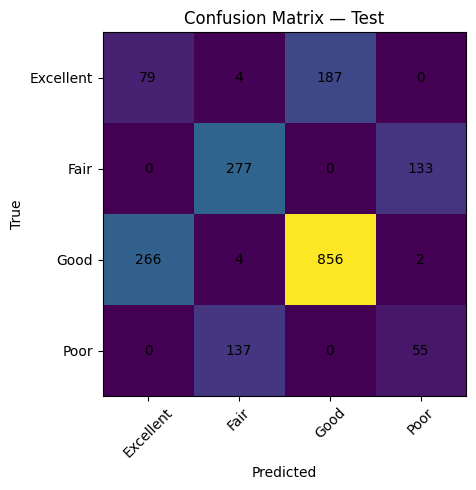

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

final_pipe = Pipeline(
    [
        ("prep", preprocess),
        (
            "model",
            candidates[best_tuned["model"]]["est"].__class__(
                **candidates[best_tuned["model"]]["est"].get_params()
            ),
        ),
    ]
)
final_pipe.set_params(**best_tuned["params"])
final_pipe.fit(X_trainval, y_trainval)

y_test_pred = final_pipe.predict(X_test)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=final_pipe.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm)

ax.set_xticks(np.arange(len(final_pipe.classes_)))
ax.set_yticks(np.arange(len(final_pipe.classes_)))
ax.set_xticklabels(final_pipe.classes_, rotation=45)
ax.set_yticklabels(final_pipe.classes_)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix — Test")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()

In [36]:
X2_trainval = pd.concat([X2_train, X2_val], axis=0)
y2_trainval = pd.concat([y2_train, y2_val], axis=0)

final_pipe_noHI = Pipeline(
    [
        ("prep", preprocess2),
        (
            "model",
            candidates[best2_tuned["model"]]["est"].__class__(
                **candidates[best2_tuned["model"]]["est"].get_params()
            ),
        ),
    ]
)
final_pipe_noHI.set_params(**best2_tuned["params"])
final_pipe_noHI.fit(X2_trainval, y2_trainval)


y2_test_pred = final_pipe_noHI.predict(X2_test)
print(
    "Balanced Accuracy (no Health_Issues):",
    balanced_accuracy_score(y2_test, y2_test_pred),
)
print(classification_report(y2_test, y2_test_pred))


def macro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")


test_compare = pd.DataFrame(
    {
        "macroF1_with_HI": [macro_f1(y_test, y_test_pred)],
        "balAcc_with_HI": [balanced_accuracy_score(y_test, y_test_pred)],
        "macroF1_no_HI": [macro_f1(y2_test, y2_test_pred)],
        "balAcc_no_HI": [balanced_accuracy_score(y2_test, y2_test_pred)],
        "delta_macroF1": [
            macro_f1(y2_test, y2_test_pred) - macro_f1(y_test, y_test_pred)
        ],
        "delta_balAcc": [
            balanced_accuracy_score(y2_test, y2_test_pred)
            - balanced_accuracy_score(y_test, y_test_pred)
        ],
    }
)

test_compare

Balanced Accuracy (no Health_Issues): 0.2865373457590959
              precision    recall  f1-score   support

   Excellent       0.20      0.24      0.22       270
        Fair       0.24      0.25      0.24       410
        Good       0.57      0.50      0.53      1128
        Poor       0.12      0.16      0.13       192

    accuracy                           0.38      2000
   macro avg       0.28      0.29      0.28      2000
weighted avg       0.41      0.38      0.39      2000



,macroF1_with_HI,balAcc_with_HI,macroF1_no_HI,balAcc_no_HI,delta_macroF1,delta_balAcc
0,0.499828,0.503381,0.281932,0.286537,-0.217895,-0.216844
